In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

### Load CSV and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load your CSV
df = pd.read_csv("/content/drive/My Drive/Emotion_model/fer2013.csv")

# Convert 'pixels' column to numpy arrays
pixels = df['pixels'].tolist()
X = np.array([np.fromstring(p, sep=' ').reshape(48,48,1) for p in pixels], dtype='float32') / 255.0

# One-hot encode labels
Y = to_categorical(df['emotion'].values, num_classes=7)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (35887, 48, 48, 1)
Y shape: (35887, 7)


### Split Data into Train, Validation, Test

In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, 10% val, 10% test
train_X, temp_X, train_Y, temp_Y = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=df['emotion'])
val_X, test_X, val_Y, test_Y = train_test_split(temp_X, temp_Y, test_size=0.5, random_state=42, stratify=temp_Y.argmax(axis=1))

print("Train:", train_X.shape, train_Y.shape)
print("Validation:", val_X.shape, val_Y.shape)
print("Test:", test_X.shape, test_Y.shape)

Train: (28709, 48, 48, 1) (28709, 7)
Validation: (3589, 48, 48, 1) (3589, 7)
Test: (3589, 48, 48, 1) (3589, 7)


### Load Your Saved Model

In [ ]:
model = load_model("/content/drive/My Drive/Emotion_model/DeepS_emotion_model.keras", compile=False)

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Example: augment entire train set (or just fear/sad)
train_datagen = datagen.flow(train_X, train_Y, batch_size=64)

### Use Class Weights for Fear & Sad

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot Y to single label for class_weight
y_integers = np.argmax(train_Y, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.035155404918151), 1: np.float64(9.363666014350946), 2: np.float64(1.0010460615781582), 3: np.float64(0.5703359357927568), 4: np.float64(0.8437123460781144), 5: np.float64(1.2808512536807353), 6: np.float64(0.8272056704892525)}


### Fine-Tune the Model

In [ ]:
# Freeze early layers if you want
for layer in model.layers[:-3]:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=10,
    batch_size=64,
    class_weight=class_weights_dict
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - accuracy: 0.6238 - loss: 0.9448 - val_accuracy: 0.6620 - val_loss: 0.8956
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.6245 - loss: 0.9428 - val_accuracy: 0.6461 - val_loss: 0.9465
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.6200 - loss: 0.9548 - val_accuracy: 0.6606 - val_loss: 0.8856
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 584s 1s/step - accuracy: 0.6267 - loss: 0.9458 - val_accuracy: 0.6570 - val_loss: 0.9021
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.6192 - loss: 0.9425 - val_accuracy: 0.6631 - val_loss: 0.8953
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.6247 - loss: 0.9309 - val_accuracy: 0.6645 - val_loss: 0.8884
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.6231 - loss: 0.9259 - val_accuracy: 0.6620 - val_loss: 0.9074
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.6277 - loss: 0.9395 - val_accu

### Evaluate on Test Set

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_X)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_Y, axis=1)

print(classification_report(true_labels, pred_labels, target_names=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step
              precision    recall  f1-score   support

       happy       0.63      0.52      0.57       496
         sad       0.42      0.93      0.57        54
        fear       0.57      0.39      0.47       512
       anger       0.90      0.84      0.87       899
     disgust       0.54      0.61      0.57       608
    surprise       0.70      0.87      0.77       400
     neutral       0.63      0.70      0.66       620

    accuracy                           0.67      3589
   macro avg       0.63      0.69      0.64      3589
weighted avg       0.68      0.67      0.67      3589



### Plot Confusion Matrix

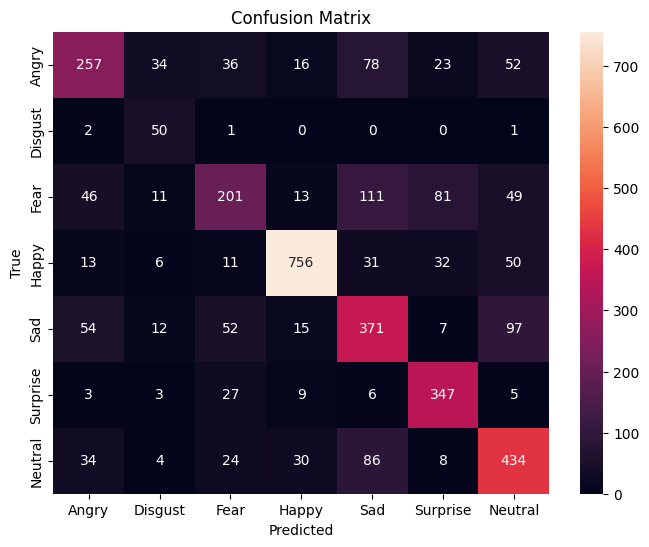

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, pred_labels)
CLASS_NAMES = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### More Data Augmentation for Fear and Sad

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Targeted augmentation only for fear and sad
fear_sad_indices = np.where(np.argmax(train_Y, axis=1) == 4)[0]  # sad = 4
fear_sad_indices = np.concatenate((fear_sad_indices, np.where(np.argmax(train_Y, axis=1) == 2)[0]))  # fear = 2

fear_sad_X = train_X[fear_sad_indices]
fear_sad_Y = train_Y[fear_sad_indices]

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

augmented_data = datagen.flow(fear_sad_X, fear_sad_Y, batch_size=32)

### Learning Rate Reduction and Early Stopping

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Reduce LR when val_loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Stop training early if val_loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)


### Fine-Tune Model with Improvements

In [ ]:
# Optionally freeze base layers
for layer in model.layers[:-3]:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with augmented data, class weights, LR reduction, and early stopping
history = model.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.6244 - loss: 0.9360 - val_accuracy: 0.6481 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.6196 - loss: 0.9494 - val_accuracy: 0.6634 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.6254 - loss: 0.9515 - val_accuracy: 0.6612 - val_loss: 0.8935 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - accuracy: 0.6229 - loss: 0.9513 - val_accuracy: 0.6537 - val_loss: 0.9035 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.6288 - loss: 0.9306 - val_accuracy: 0.6612 - val_loss: 0.8978 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6260 - loss: 0.9359
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
449/449 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.6260 - loss: 0.935

### Re-Evaluate

In [ ]:
predictions = model.predict(test_X)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_Y, axis=1)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]))

# Confusion matrix (plot again)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"], yticklabels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()